In [3]:
# Imports
import pandas as pd
import numpy as np
from __future__ import print_function

%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Read in raw data
schoolData = pd.read_csv('https://raw.githubusercontent.com/kevimwe/NC_EDUCATION_DATA/master/NC_EDUC_Visualization_Data_Processing/data/All_Data_By_School_Final.csv'
                         , low_memory=False)
testScores = pd.read_csv('https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/1516_Test_Scores.csv', low_memory=False)

#Review raw data before the join
schoolData.info()

#join files using school / unit code
schoolData = schoolData.merge(testScores, on='unit_code', how='left', suffixes=('_schoolData', '_testScores'))

#Review raw data after the join to make sure new fields were added
print('************************************************************')
schoolData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 293 entries, Year to State_Prin_Exp_Pct_10+_Years
dtypes: float64(255), int64(17), object(21)
memory usage: 5.8+ MB
************************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 365 entries, Year to Passing_Math_III
dtypes: float64(324), int64(17), object(24)
memory usage: 7.2+ MB


In [4]:
#Remove fields not needed for machine learning
excludeFields = ['Year','unit_code_schoolData', 'street_ad','scity_ad','state_ad','szip_ad','Closed_Ind_Text','New_ind_Txt',
                 'grades_BYOD','grades_1_to_1_access','District Name','unit_code_testScores','School Name','SBE District']

keepFields = [col for col in schoolData.columns if col not in excludeFields]

schoolData = schoolData[keepFields]

schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 353 entries, unit_code to Passing_Math_III
dtypes: float64(324), int64(15), object(14)
memory usage: 7.0+ MB


In [5]:
#Clean up the dataset for machine learning 
boolFields = ['title1_type_flg', 'clp_ind_flg', 'focus_clp_flg', 'summer_program_flg', 
              'asm_no_spg_flg', 'no_data_spg_flg', 'stem_flg']

# Map flag fields into bool 
schoolData['title1_type_flg'] = schoolData['title1_type_flg'].map({-1:True, 0:False})
schoolData['clp_ind_flg'] = schoolData['clp_ind_flg'].map({-1:True, 0:False})
schoolData['focus_clp_flg'] = schoolData['focus_clp_flg'].map({-1:True, 0:False})
schoolData['summer_program_flg'] = schoolData['summer_program_flg'].map({-1:True, 0:False})
schoolData['asm_no_spg_flg'] = schoolData['asm_no_spg_flg'].map({-1:True, 0:False})
schoolData['no_data_spg_flg'] = schoolData['no_data_spg_flg'].map({-1:True, 0:False})
schoolData['stem_flg'] = schoolData['stem_flg'].map({-1:True, 0:False})

#
schoolData['esea_status'] = schoolData['esea_status'].map({'P':'Esea_Pass', 'F':'Esea_Fail', np.nan:'Non_Esea'})
schoolData['Grad_project_status'] = schoolData['Grad_project_status'].map({'Y':True, 'N':False, np.nan:False})

In [6]:
# Find all the categorical variables
schoolData_Bool = schoolData.loc[:, schoolData.dtypes == bool]
schoolData_Vars = schoolData.loc[:, schoolData.dtypes == object]
cat_list_obj = list(pd.concat([schoolData_Vars, schoolData_Bool]))
cat_list_obj_len = len(cat_list_obj) # number of object attributes
print("Number of Categorical Attributes = ", cat_list_obj_len)
cat_list_obj

Number of Categorical Attributes =  21


['1_to_1_access',
 'Byod',
 'EVAAS Growth Status',
 'Grad_project_status',
 'Math SPG Grade',
 'Reading SPG Grade',
 'SPG Grade',
 'State Gap Compared',
 'asm_no_spg_flg',
 'calendar_only_txt',
 'category_cd',
 'clp_ind_flg',
 'esea_status',
 'focus_clp_flg',
 'no_data_spg_flg',
 'school_type_txt',
 'stem_flg',
 'summer_program_flg',
 'title1_type_flg',
 'type_cd_txt',
 'unit_code']

In [7]:
#Review individual data types after data preparation
schoolData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Data columns (total 353 columns):
unit_code                                         object
type_cd_txt                                       object
category_cd                                       object
school_type_txt                                   object
calendar_only_txt                                 object
title1_type_flg                                   bool
clp_ind_flg                                       bool
focus_clp_flg                                     bool
summer_program_flg                                bool
asm_no_spg_flg                                    bool
no_data_spg_flg                                   bool
esea_status                                       object
student_num                                       float64
lea_avg_student_num                               float64
st_avg_student_num                                int64
Grad_project_status                             

In [8]:
highSchools = schoolData [((schoolData.category_cd == 'H') | 
                          (schoolData.category_cd == 'T') | 
                          (schoolData.category_cd == 'A'))&
                          (schoolData.Graduation_Rate4_Yr > 0) &
                          (schoolData.student_num > 0) & 
                          (schoolData.type_cd_txt == 'Public') & 
                          (schoolData.school_type_txt == 'Regular School')
                         ]

highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 2 to 2419
Columns: 353 entries, unit_code to Passing_Math_III
dtypes: bool(8), float64(324), int64(8), object(13)
memory usage: 1.2+ MB


In [10]:
#Inspect the high school data fields 
df_temp = highSchools.describe(include='all').T
# include the data type of the column in the dataframe
df_temp['type']= highSchools.dtypes
# Reset the index of the dataframe to have index as numbers to have the number of rows visible in the output
df_temp.reset_index(inplace=True)
df_temp

,index,count,unique,top,freq,mean,std,min,25%,50%,75%,max,type
0,unit_code,463,463,110336,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
1,type_cd_txt,463,1,Public,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
2,category_cd,463,3,H,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
3,school_type_txt,463,1,Regular School,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
4,calendar_only_txt,463,2,Traditional Calendar,456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
5,title1_type_flg,463,2,False,427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool
6,clp_ind_flg,463,2,False,407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool
7,focus_clp_flg,463,2,False,411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool
8,summer_program_flg,463,2,False,289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool
9,asm_no_spg_flg,463,1,False,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool


In [11]:
#List of all int32 fields
int32Fields = ['student_num', 'lea_avg_student_num','Avg_Class_Size_00','Avg_Class_Size_01',
             'Avg_Class_Size_02','Avg_Class_Size_03','Avg_Class_Size_04','Avg_Class_Size_05',
             'Avg_Class_Size_06','Avg_Class_Size_07','Avg_Class_Size_08','Avg_Class_Size_Biology',
             'Avg_Class_Size_EnglishII','Avg_Class_Size_MathI','Avg_Dist_Size_00','Avg_Dist_Size_01',
             'Avg_Dist_Size_02','Avg_Dist_Size_03','Avg_Dist_Size_04','Avg_Dist_Size_05','Avg_Dist_Size_06',
             'Avg_Dist_Size_07','Avg_Dist_Size_08','Avg_Dist_Size_Biology','Avg_Dist_Size_EnglishII',
             'Avg_State_Size_04','Avg_State_Size_05','Avg_State_Size_06','Avg_State_Size_07','Avg_State_Size_08',
             'Avg_State_Size_Biology','Avg_State_Size_EnglishII','Avg_State_Size_MathI','SPG Score','Reading  SPG Score',
             'Math SPG Score','Overall Achievement Score','Read Score','Math Score','Science Score','Math I Score',
             'English II Score','Biology Score','The ACT Score','ACT WorkKeys Score','Math Course Rigor Score',
             'Cohort Graduation Rate Standard Score','sat_avg_score_num','lea_sat_avg_score_num','st_sat_avg_score_num',
             'nat_sat_avg_score_num','avg_age_media_collection','lea_avg_age_media_collection','st_avg_age_media_collection',
             'wap_num','lea_wap_num','st_wap_num','class_teach_num','nbpts_num','lea_class_teach_num','lea_nbpts_num',
             'st_class_teach_num','st_nbpts_num']

In [12]:
#High school - excluded fields and reasons
excludeFeaturesHS = ['no_data_spg_flg', #all false or NaN
 'Avg_Class_Size_00', #NA for High Schools
 'Avg_Class_Size_01', #NA for High Schools
 'Avg_Class_Size_02', #NA for High Schools
 'Avg_Class_Size_03', #NA for High Schools
 'Avg_Class_Size_04', #NA for High Schools
 'Avg_Class_Size_05', #NA for High Schools
 'Avg_Class_Size_06', #NA for High Schools
 'Avg_Class_Size_07', #NA for High Schools
 'Avg_Class_Size_08', #NA for High Schools
 'Avg_Dist_Size_00', #NA for High Schools
 'Avg_Dist_Size_01', #NA for High Schools
 'Avg_Dist_Size_02', #NA for High Schools
 'Avg_Dist_Size_03', #NA for High Schools
 'Avg_Dist_Size_04', #NA for High Schools
 'Avg_Dist_Size_05', #NA for High Schools
 'Avg_Dist_Size_06', #NA for High Schools
 'Avg_Dist_Size_07', #NA for High Schools
 'Avg_Dist_Size_08', #NA for High Schools
 'Avg_State_Size_00', #NA for High Schools
 'Avg_State_Size_01', #NA for High Schools
 'Avg_State_Size_02', #NA for High Schools
 'Avg_State_Size_03', #NA for High Schools
 'Avg_State_Size_04', #NA for High Schools
 'Avg_State_Size_05', #NA for High Schools
 'Avg_State_Size_06', #NA for High Schools
 'Avg_State_Size_07', #NA for High Schools
 'Avg_State_Size_08', #NA for High Schools
 'total_expense_num', #494 NaN
 'salary_expense_pct', #494 NaN
 'services_expense_pct', #494 NaN
 'supplies_expense_pct', #494 NaN
 'instruct_equip_exp_pct', #494 NaN
 'other_expense_pct', #494 NaN
 'federal_perpupil_num', #494 NaN
 'local_perpupil_num', #494 NaN
 'state_perpupil_num', #494 NaN
 'lea_other_expense_pct', #All 0 or NaN
 'st_total_expense_num', #Same Value
 'st_salary_expense_pct', #Same Value
 'st_benefits_expense_pct', #Same Value
 'st_services_expense_pct', #Same Value
 'st_supplies_expense_pct', #Same Value
 'st_instruct_equip_exp_pct', #Same Value
 'st_other_expense_pct', #Same Value
 'st_federal_perpupil_num', #Same Value
 'st_local_perpupil_num', #Same Value
 'st_state_perpupil_num', #Same Value
 'Reading SPG Grade', #NA for High Schools
 'Reading  SPG Score', #NA for High Schools
 'Math SPG Grade', #NA for High Schools
 'Math SPG Score', #NA for High Schools
 'Read Score', #NA for High Schools
 'Math Score', #NA for High Schools
 'Science Score', #NA for High Schools
 'ACT WorkKeys Score', #81 NaN
 'GCE_LEP_School_Pct', #440 NaN
 'GCE_PRM_School_Pct', #440 NaN
 'GCE_RPF_School_Pct', #440 NaN
 'GCE_SWD_School_Pct', #440 NaN
 'PASSED_EOG_School_Pct', #438 NaN
 'PASSED_LAA_School_Pct', #440 NaN
 'PASSED_RTA_School_Pct', #440 NaN
 'PROMOTED_School_Pct', #438 NaN
 'RETAINED_School_Pct', #440 NaN
 'GCE_ALL_Dist_Pct', #437 NaN
 'GCE_LEP_Dist_Pct', #440 NaN
 'GCE_PRM_Dist_Pct', #440 NaN
 'GCE_RPF_Dist_Pct', #439 NaN
 'GCE_SWD_Dist_Pct', #438 NaN
 'PASSED_EOG_Dist_Pct', #437 NaN
 'PASSED_LAA_Dist_Pct', #438 NaN
 'PASSED_RTA_Dist_Pct', #440 NaN
 'PROMOTED_Dist_Pct', #437 NaN
 'RETAINED_Dist_Pct', #438 NaN
 'GCE_ALL_State_Pct', #437 NaN
 'GCE_LEP_State_Pct', #440 NaN
 'GCE_PRM_State_Pct', #440 NaN
 'GCE_RPF_State_Pct', #440 NaN
 'GCE_SWD_State_Pct', #437 NaN
 'PASSED_EOG_State_Pct', #437 NaN
 'PASSED_LAA_State_Pct', #437 NaN
 'PASSED_RTA_State_Pct', #440 NaN
 'PROMOTED_State_Pct', #437 NaN
 'RETAINED_State_Pct', #437 NaN
 'st_sat_avg_score_num  ', #All Same Value 
 'nat_sat_avg_score_num', #All Same Value
 'st_sat_participation_pct', #All Same Value 
 'nat_sat_participation_pct', #All Same Value
 'esea_attendance', #440 NaN
 'lea_esea_attendance', #440 NaN
 'st_ap_participation_pct', #All Same Value
 'st_ap_pct_3_or_above', #All Same Value
 'ib_participation_pct', #434 NaN
 'lea_ib_participation_pct', #440 NaN
 'st_ib_participation_pct', #440 NaN
 'ib_pct_4_or_above', #416 NaN
 'lea_ib_pct_4_or_above', #261 NaN
 'st_ib_pct_4_or_above', #All Same Value
 'st_total_specialized_courses', #All Same Value
 'st_ap_ib_courses ', #All Same Value
 'st_cte_courses', #All Same Value
 'st_univ_college_courses', #All Same Value
 'ttl_crimes_num', #440 NaN
 'st_expelled_per_c_num', #All Same Value
 'st_avg_age_media_collection ', #All Same Value
 'st_books_per_student', #All Same Value
 'st_wap_num', #All Same Value
 'st_wap_per_classroom', #All Same Value
 'prin_other_pct', #440 NaN
 'prinyrs_0thru3_pct', #440 NaN
 'prinyrs_4thru10_pct', #440 NaN
 'prinyrs_11plus_pct', #440 NaN
 'prin_advance_dgr_pct', #440 NaN
 '_1yr_prin_trnovr_pct', #440 NaN
 'prin_male_pct', #440 NaN
 'prin_female_pct', #440 NaN
 'prin_black_pct', #440 NaN
 'prin_white_pct', #440 NaN
 'emer_prov_teach_pct    ', #385 NaN 
 'st_highqual_class_hp_pct ', #All Same Value
 'st_highqual_class_lp_pct ', #All Same Value
 'st_highqual_class_all_pct ', #All Same Value
 'st_not_highqual_class_hp_pct ', #All Same Value
 'st_not_highqual_class_lp_pct ', #All Same Value
 'st_not_highqual_class_all_pct ', #All Same Value
 'st_prinyrs_0thru3_pct ', #All Same Value
 'st_prinyrs_4thru10_pct ', #All Same Value
 'st_prinyrs_11plus_pct', #All Same Value
 'st_prin_advance_dgr_pct', #All Same Value
 'st_1yr_prin_trnovr_pct ', #All Same Value
 'st_prin_male_pct ', #All Same Value
 'st_prin_female_pct ', #All Same Value
 'st_prin_black_pct ', #All Same Value
 'st_prin_white_pct', #All Same Value
 'st_prin_other_pct', #All Same Value
 'State_Prin_Exp_Pct_0_3_Years ', #All Same Value
 'State_Prin_Exp_Pct_4_10_Years ', #All Same Value
 'State_Prin_Exp_Pct_10+_Years ', #All Same Value
 'All_EOG_Subjects_CACR', #428 NaN 
 'All_EOG_Subjects_GLP', #428 NaN 
 'EOG_Gr3_CACR', #NA for High Schools
 'EOG_Gr3_GLP', #NA for High Schools
 'EOG_Gr4_CACR', #NA for High Schools
 'EOG_Gr4_GLP', #NA for High Schools
 'EOG_Gr5_CACR', #NA for High Schools
 'EOG_Gr5_GLP', #NA for High Schools
 'EOG_Gr6_CACR', #NA for High Schools
 'EOG_Gr6_GLP', #NA for High Schools
 'EOG_Gr7_CACR', #NA for High Schools
 'EOG_Gr7_GLP', #NA for High Schools
 'EOG_Gr8_CACR', #NA for High Schools
 'EOG_Gr8_GLP', #NA for High Schools
 'EOG_Math_Gr3_CACR', #NA for High Schools
 'EOG_Math_Gr3_GLP', #NA for High Schools
 'EOG_Math_Gr3-8_CACR', #NA for High Schools
 'EOG_Math_Gr3-8_GLP', #NA for High Schools
 'EOG_Math_Gr4_CACR', #NA for High Schools
 'EOG_Math_Gr4_GLP', #NA for High Schools
 'EOG_Math_Gr5_CACR', #NA for High Schools
 'EOG_Math_Gr5_GLP', #NA for High Schools
 'EOG_Math_Gr6_CACR', #NA for High Schools
 'EOG_Math_Gr6_GLP', #NA for High Schools
 'EOG_Math_Gr7_CACR', #NA for High Schools
 'EOG_Math_Gr7_GLP', #NA for High Schools
 'EOG_Math_Gr8_CACR', #NA for High Schools
 'EOG_Math_Gr8_GLP', #NA for High Schools
 'EOG_Reading_G3_GLP', #NA for High Schools
 'EOG_Reading_Gr3_CACR', #NA for High Schools
 'EOG_Reading_Gr4_CACR', #NA for High Schools
 'EOG_Reading_Gr4_GLP', #NA for High Schools
 'EOG_Reading_Gr5_CACR', #NA for High Schools
 'EOG_Reading_Gr5_GLP', #NA for High Schools
 'EOG_Reading_Gr6_CACR', #NA for High Schools
 'EOG_Reading_Gr6_GLP', #NA for High Schools
 'EOG_Reading_Gr7_CACR', #NA for High Schools
 'EOG_Reading_Gr7_GLP', #NA for High Schools
 'EOG_Reading_Gr8_CACR', #NA for High Schools
 'EOG_Reading_Gr8_GLP', #NA for High Schools
 'EOG_Reading_Grades_3_8_CACR', #NA for High Schools
 'EOG_Reading_Grades_3_8_GLP', #NA for High Schools
 'EOG_Science_Gr5_CACR', #NA for High Schools
 'EOG_Science_Gr5_GLP', #NA for High Schools
 'EOG_Science_Gr8_CACR', #NA for High Schools
 'EOG_Science_Gr8_GLP', #NA for High Schools
 'EOG_Science_Grades_5&8_CACR', #NA for High Schools
 'EOG_Science_Grades_5&8_GLP', #NA for High Schools
 'Graduation_Rate_5_Yr', #Using 4 year graduation rate as response variable
 'type_cd_txt', #Only 'Public' after filter
 'school_type_txt', #Only 'Regular School' after filter 
 'asm_no_spg_flg', #All False after filters
 'benefits_expense_pct', #440 NaN
 'State Gap Compared', #360 NaN
 'GCE_ALL_School_Pct', #437
 'emer_prov_teach_pct', #385 NaN
 'lea_emer_prov_teach_pct', #226 NaN 
 'Avg_State_Size_Biology', #All same value
 'Avg_State_Size_EnglishII', #All same value
 'Avg_State_Size_MathI', #All same value
 'st_sat_avg_score_num', #All same value 
 'st_ap_ib_courses', #All same value
 'st_avg_daily_attend_pct', #All same value
 'st_crime_per_c_num', #All same value
 'st_short_susp_per_c_num', #All same value
 'st_long_susp_per_c_num', #All same value
 'st_stud_internet_comp_num', #All same value
 'st_avg_age_media_collection', #All same value
 'st_flicensed_teach_pct', #All same value
 #'st_tchyrs_0thru3_pct', #All same value
 #'st_tchyrs_4thru10_pct', #All same value
 #'st_tchyrs_11plus_pct', #All same value
 'st_class_teach_num', #All same value
 'st_nbpts_num', #All same value
 'st_advance_dgr_pct', #All same value
 'st_1yr_tchr_trnovr_pct', #All same value
 'st_emer_prov_teach_pct', #All same value
 'st_lateral_teach_pct', #All same value
 'st_highqual_class_pct', #All same value
 'st_highqual_class_hp_pct', #All same value
 'st_highqual_class_lp_pct', #All same value
 'st_highqual_class_all_pct', #All same value
 'st_not_highqual_class_hp_pct', #All same value
 'st_not_highqual_class_lp_pct', #All same value
 'st_not_highqual_class_all_pct', #All same value
 'st_prinyrs_0thru3_pct', #All same value
 'st_prinyrs_4thru10_pct', #All same value
 'st_1yr_prin_trnovr_pct', #All same value
 'st_prin_male_pct', #All same value
 'st_prin_female_pct', #All same value
 'st_prin_black_pct', #All same value
 'State_Tch_Exp_Pct_0_3_Years', #All same value
 'State_Tch_Exp_Pct_4_10_Years', #All same value
 'State_Tch_Exp_Pct_10+_Years', #All same value
 'State_Prin_Exp_Pct_0_3_Years', #All same value
 'State_Prin_Exp_Pct_4_10_Years', #All same value
 'State_Prin_Exp_Pct_10+_Years', #All same value
 'st_avg_student_num', #All same value 
 'unit_code', #School primary key, different for all records
 #-----------------------Added 01/30/2018------------------------
 #Removes dup fields to avoid Multicollinearity
 'tchyrs_0thru3_pct', #Duplicate field -> Tch_Exp_Pct_0_3_Years
 'tchyrs_4thru10_pct', #Duplicate field -> Tch_Exp_Pct_4_10_Years
 'tchyrs_11plus_pct', #Duplicate field -> Tch_Exp_Pct_10+_Years
 'lea_tchyrs_0thru3_pct', #Duplicate field -> Dist_Tch_Exp_Pct_0_3_Years
 'lea_tchyrs_4thru10_pct', #Duplicate field -> Dist_Tch_Exp_Pct_4_10_Years
 'lea_tchyrs_11plus_pct', #Duplicate field -> Dist_Tch_Exp_Pct_10+_Years
 'st_tchyrs_0thru3_pct', #Duplicate field -> State_Tch_Exp_Pct_0_3_Years
 'st_tchyrs_4thru10_pct', #Duplicate field -> State_Tch_Exp_Pct_4_10_Years
 'st_tchyrs_11plus_pct', #Duplicate field -> State_Tch_Exp_Pct_10+_Years
                    ]

keepFields = [col for col in highSchools.columns if col not in excludeFeaturesHS]

highSchools = highSchools[keepFields]

highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 2 to 2419
Columns: 128 entries, category_cd to Passing_Math_III
dtypes: bool(6), float64(115), object(7)
memory usage: 447.6+ KB


In [13]:
#Review Missing values 
missing_values = highSchools.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 

#Print all rows with missing values
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(missing_values)

                                      Variable Name  Number Missing Values
11   Avg_Class_Size_Biology                          8                    
12   Avg_Class_Size_EnglishII                        7                    
13   Avg_Class_Size_MathI                            12                   
14   Avg_Dist_Size_Biology                           6                    
15   Avg_Dist_Size_EnglishII                         6                    
16   Avg_Dist_Size_MathI                             6                    
26   SPG Grade                                       25                   
27   SPG Score                                       25                   
28   EVAAS Growth Status                             31                   
29   EVAAS Growth Score                              31                   
30   Overall Achievement Score                       25                   
31   Math I Score                                    32                   
32   English II Score    

In [14]:
# Find all the high school categorical variables
schoolData_Bool = highSchools.loc[:, highSchools.dtypes == bool]
schoolData_Vars = highSchools.loc[:, highSchools.dtypes == object]
cat_list_obj = list(pd.concat([schoolData_Vars, schoolData_Bool]))
cat_list_obj_len = len(cat_list_obj) # number of object attributes
print("Number of Categorical Attributes = ", cat_list_obj_len)
cat_list_obj

Number of Categorical Attributes =  13


['1_to_1_access',
 'Byod',
 'EVAAS Growth Status',
 'Grad_project_status',
 'SPG Grade',
 'calendar_only_txt',
 'category_cd',
 'clp_ind_flg',
 'esea_status',
 'focus_clp_flg',
 'stem_flg',
 'summer_program_flg',
 'title1_type_flg']

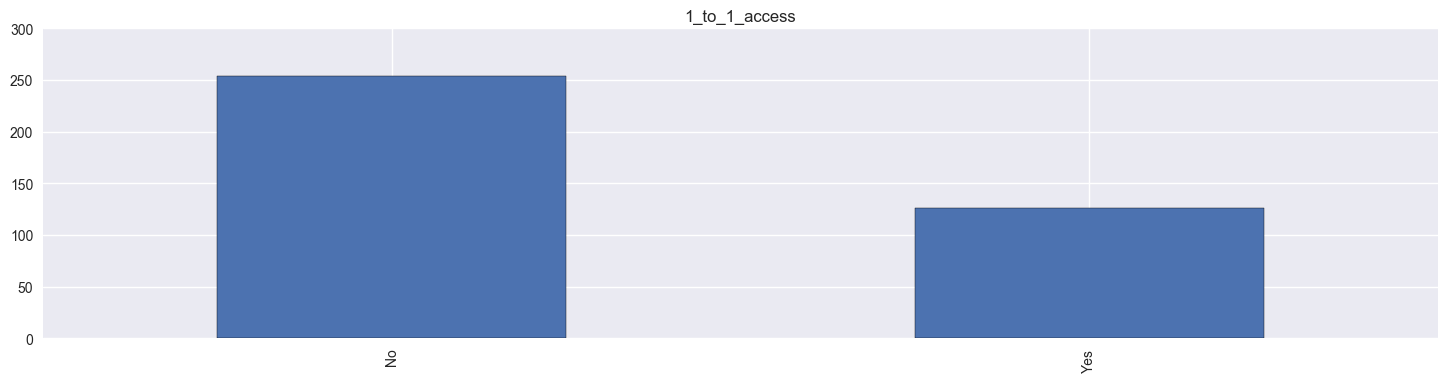

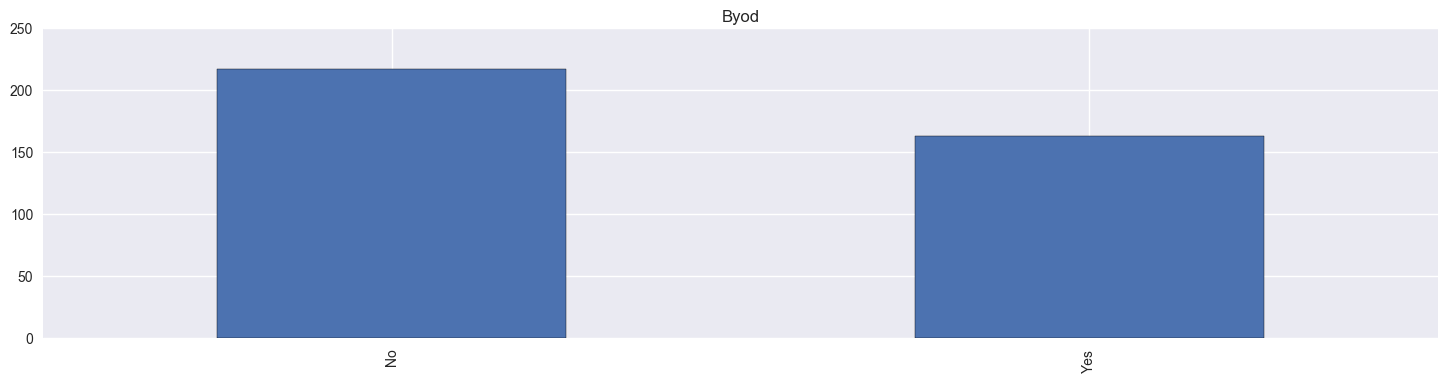

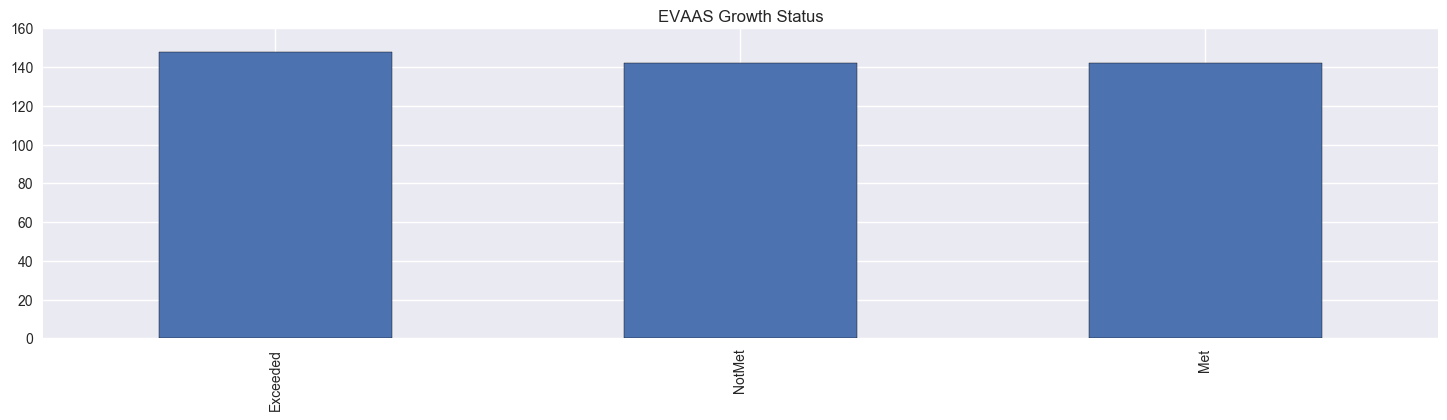

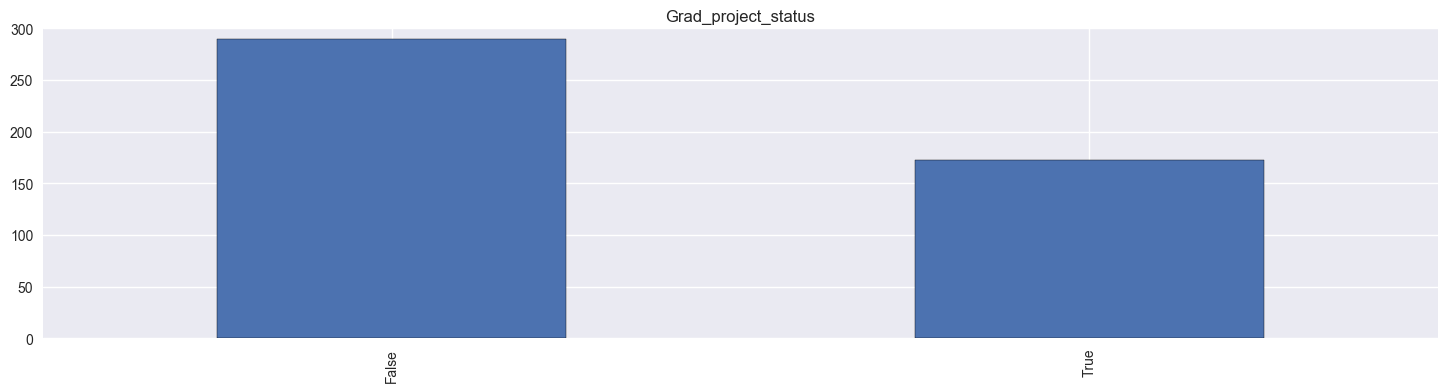

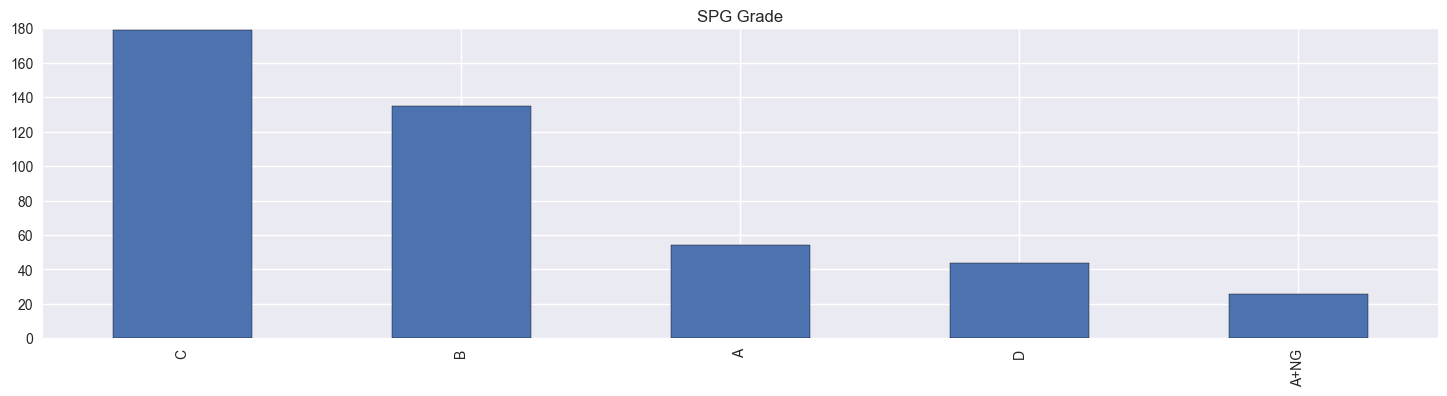

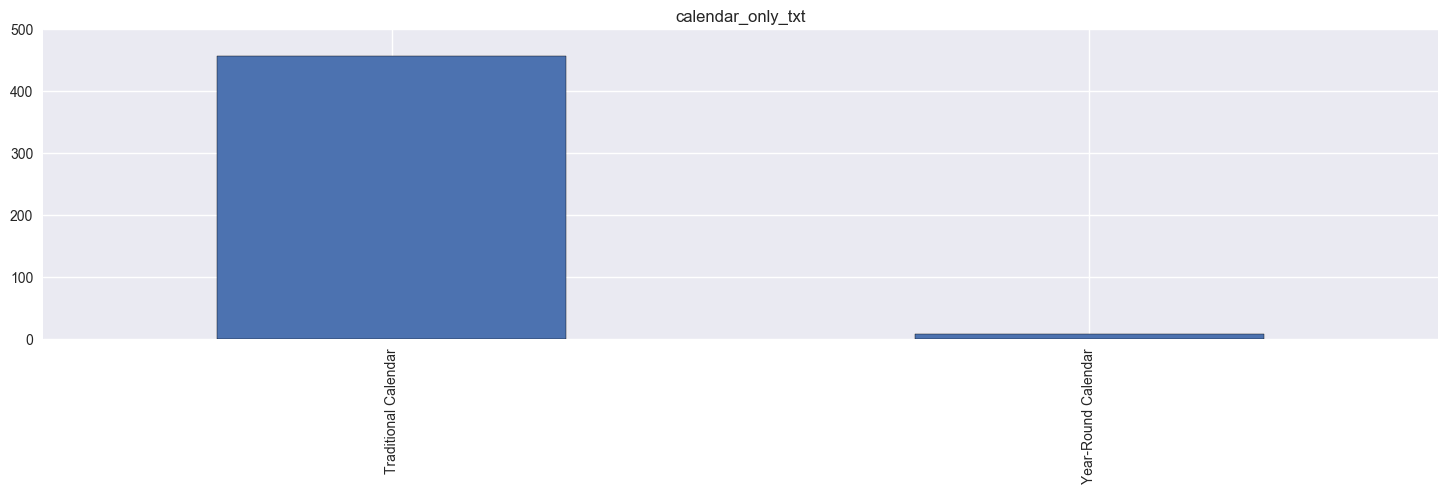

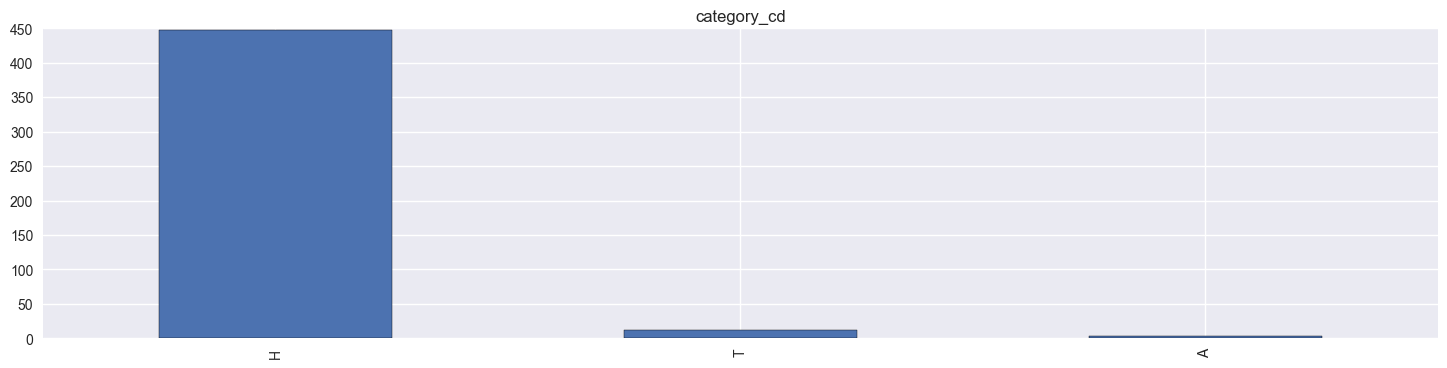

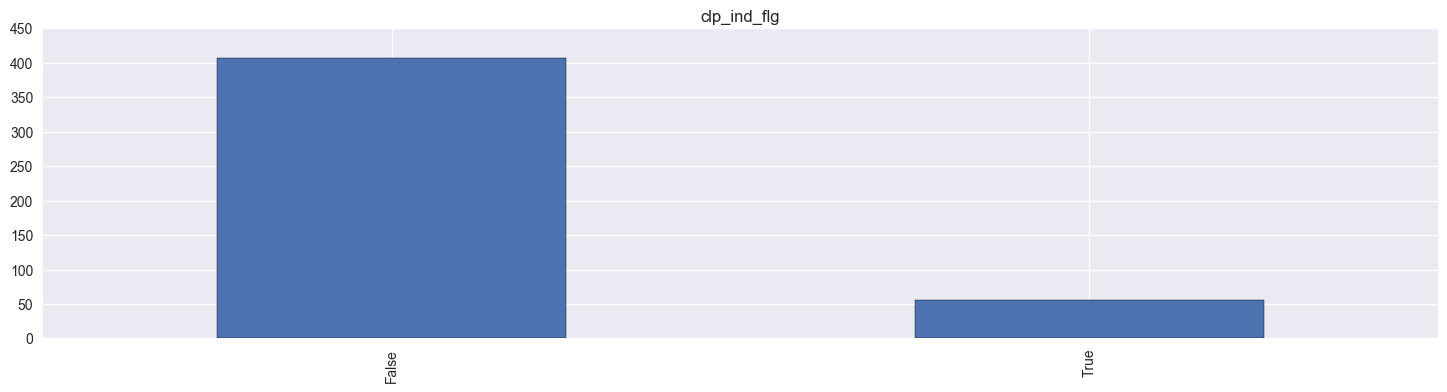

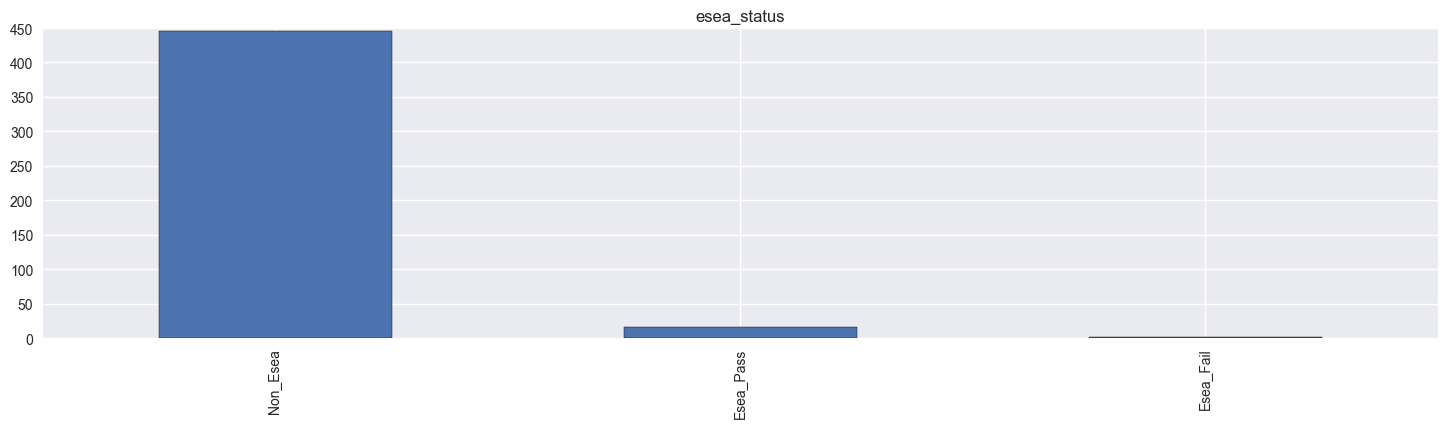

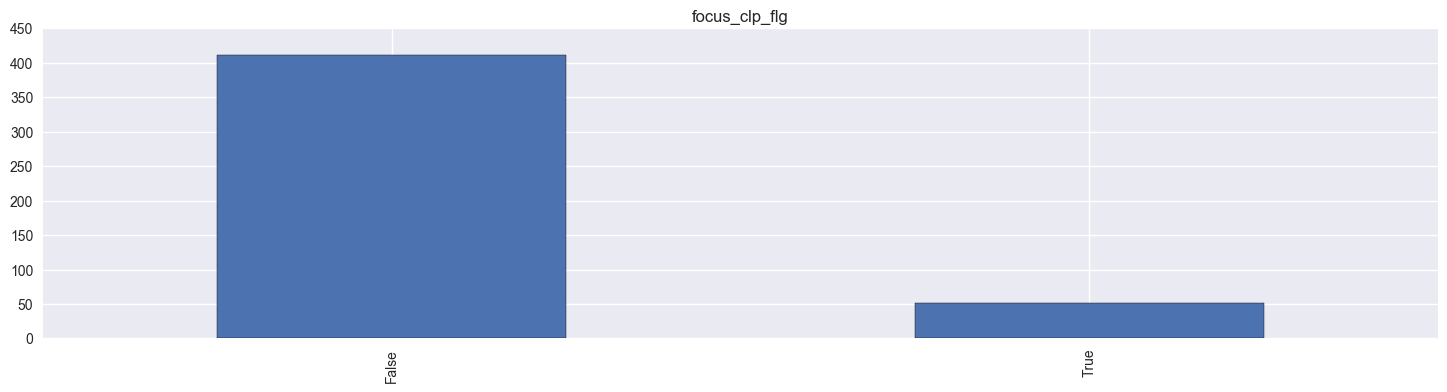

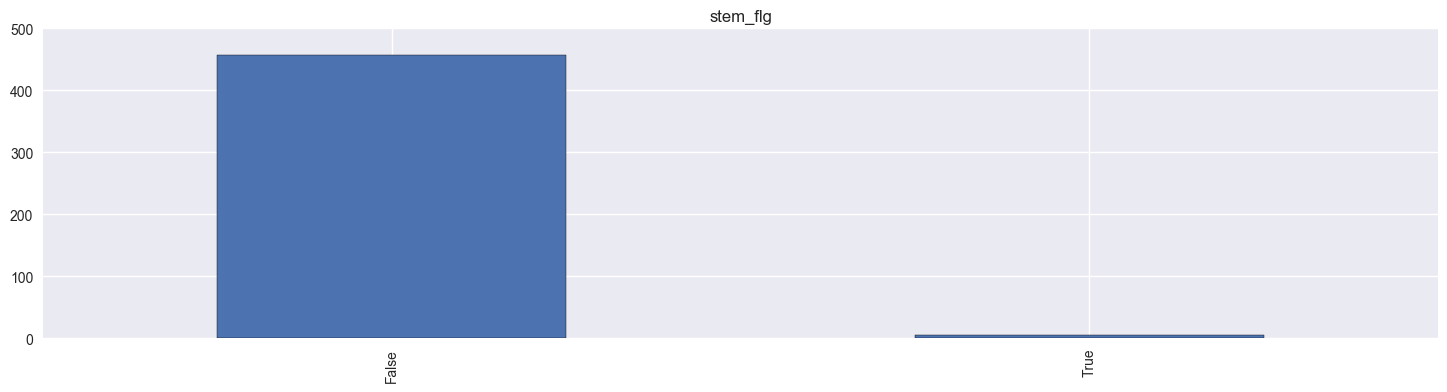

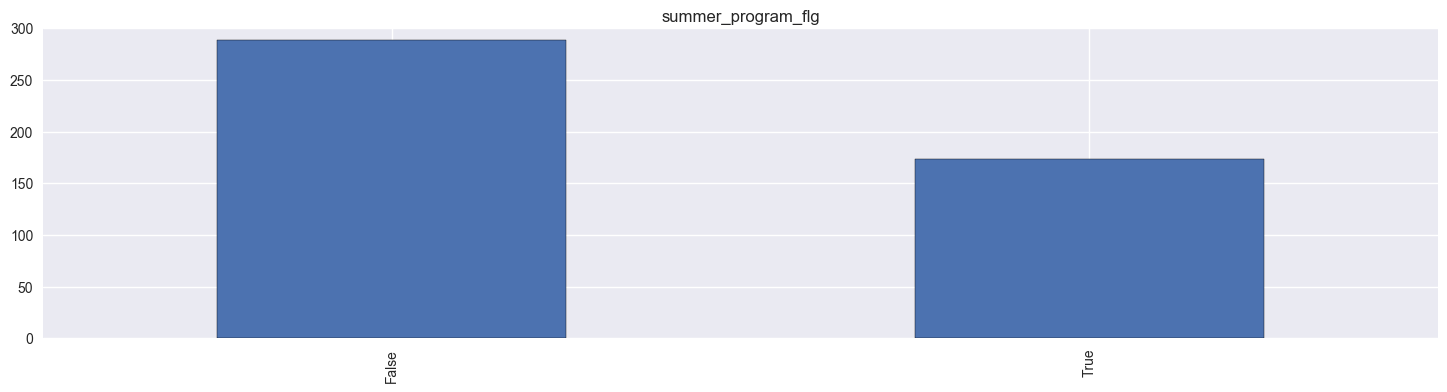

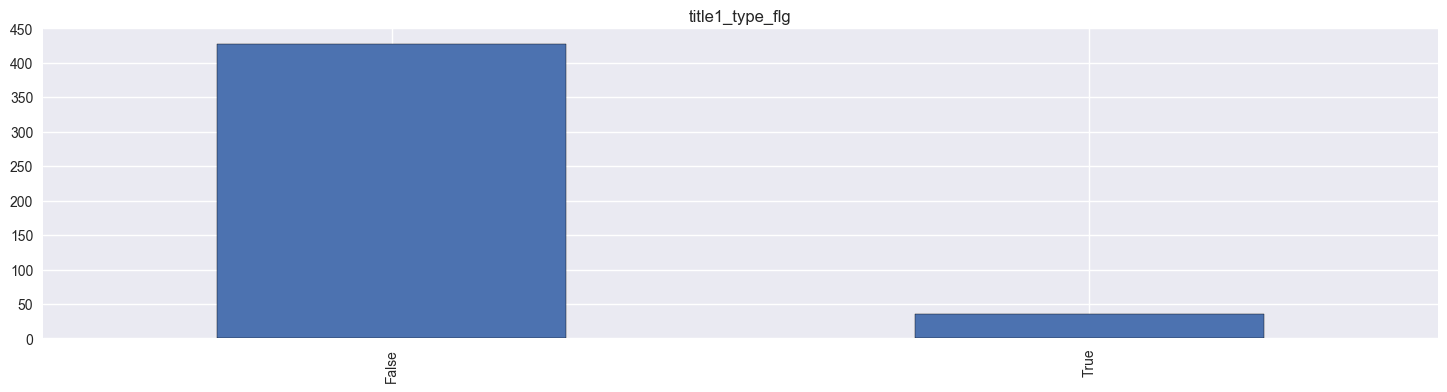

In [15]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt

# Examine high schoool categorical variables of interest 
for i in range(0,cat_list_obj_len):
    plt.figure(figsize = (18,4))
    ax = highSchools[cat_list_obj[i]].value_counts().plot(kind='bar')
    plt.title(cat_list_obj[i])
    plt.show()

In [16]:
#Convert Categorical fields to bool using get_dummies
#Use drop_first=true to aviod multicolinierarity
highSchoolsFinal = pd.get_dummies(data=highSchools, 
                       columns=['category_cd', 
                                'calendar_only_txt',
                                'esea_status',
                                'SPG Grade',
                                'EVAAS Growth Status',
                                'Byod',
                                '1_to_1_access'], drop_first=True) #Try drop_first=true to aviod multicolinierarity

highSchoolsFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 2 to 2419
Columns: 134 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(115), uint8(13)
memory usage: 428.2 KB


In [17]:
#Replace all NaN with 0
highSchoolsFinal = highSchoolsFinal.fillna(0)

#Check for Missing values again 
missing_values = highSchoolsFinal.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

,Variable Name,Number Missing Values


In [18]:
highSchoolsFinal.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 2 to 2419
Data columns (total 134 columns):
title1_type_flg                                   bool
clp_ind_flg                                       bool
focus_clp_flg                                     bool
summer_program_flg                                bool
student_num                                       float64
lea_avg_student_num                               float64
Grad_project_status                               bool
stem_flg                                          bool
Avg_Class_Size_Biology                            float64
Avg_Class_Size_EnglishII                          float64
Avg_Class_Size_MathI                              float64
Avg_Dist_Size_Biology                             float64
Avg_Dist_Size_EnglishII                           float64
Avg_Dist_Size_MathI                               float64
lea_total_expense_num                             float64
lea_salary_expense_pct                   

In [19]:
# create x explanatory and y response variable for regression
Y_highSchools = highSchoolsFinal['Graduation_Rate4_Yr'] 
X_highSchools = highSchoolsFinal.drop(['Graduation_Rate4_Yr'], axis=1)

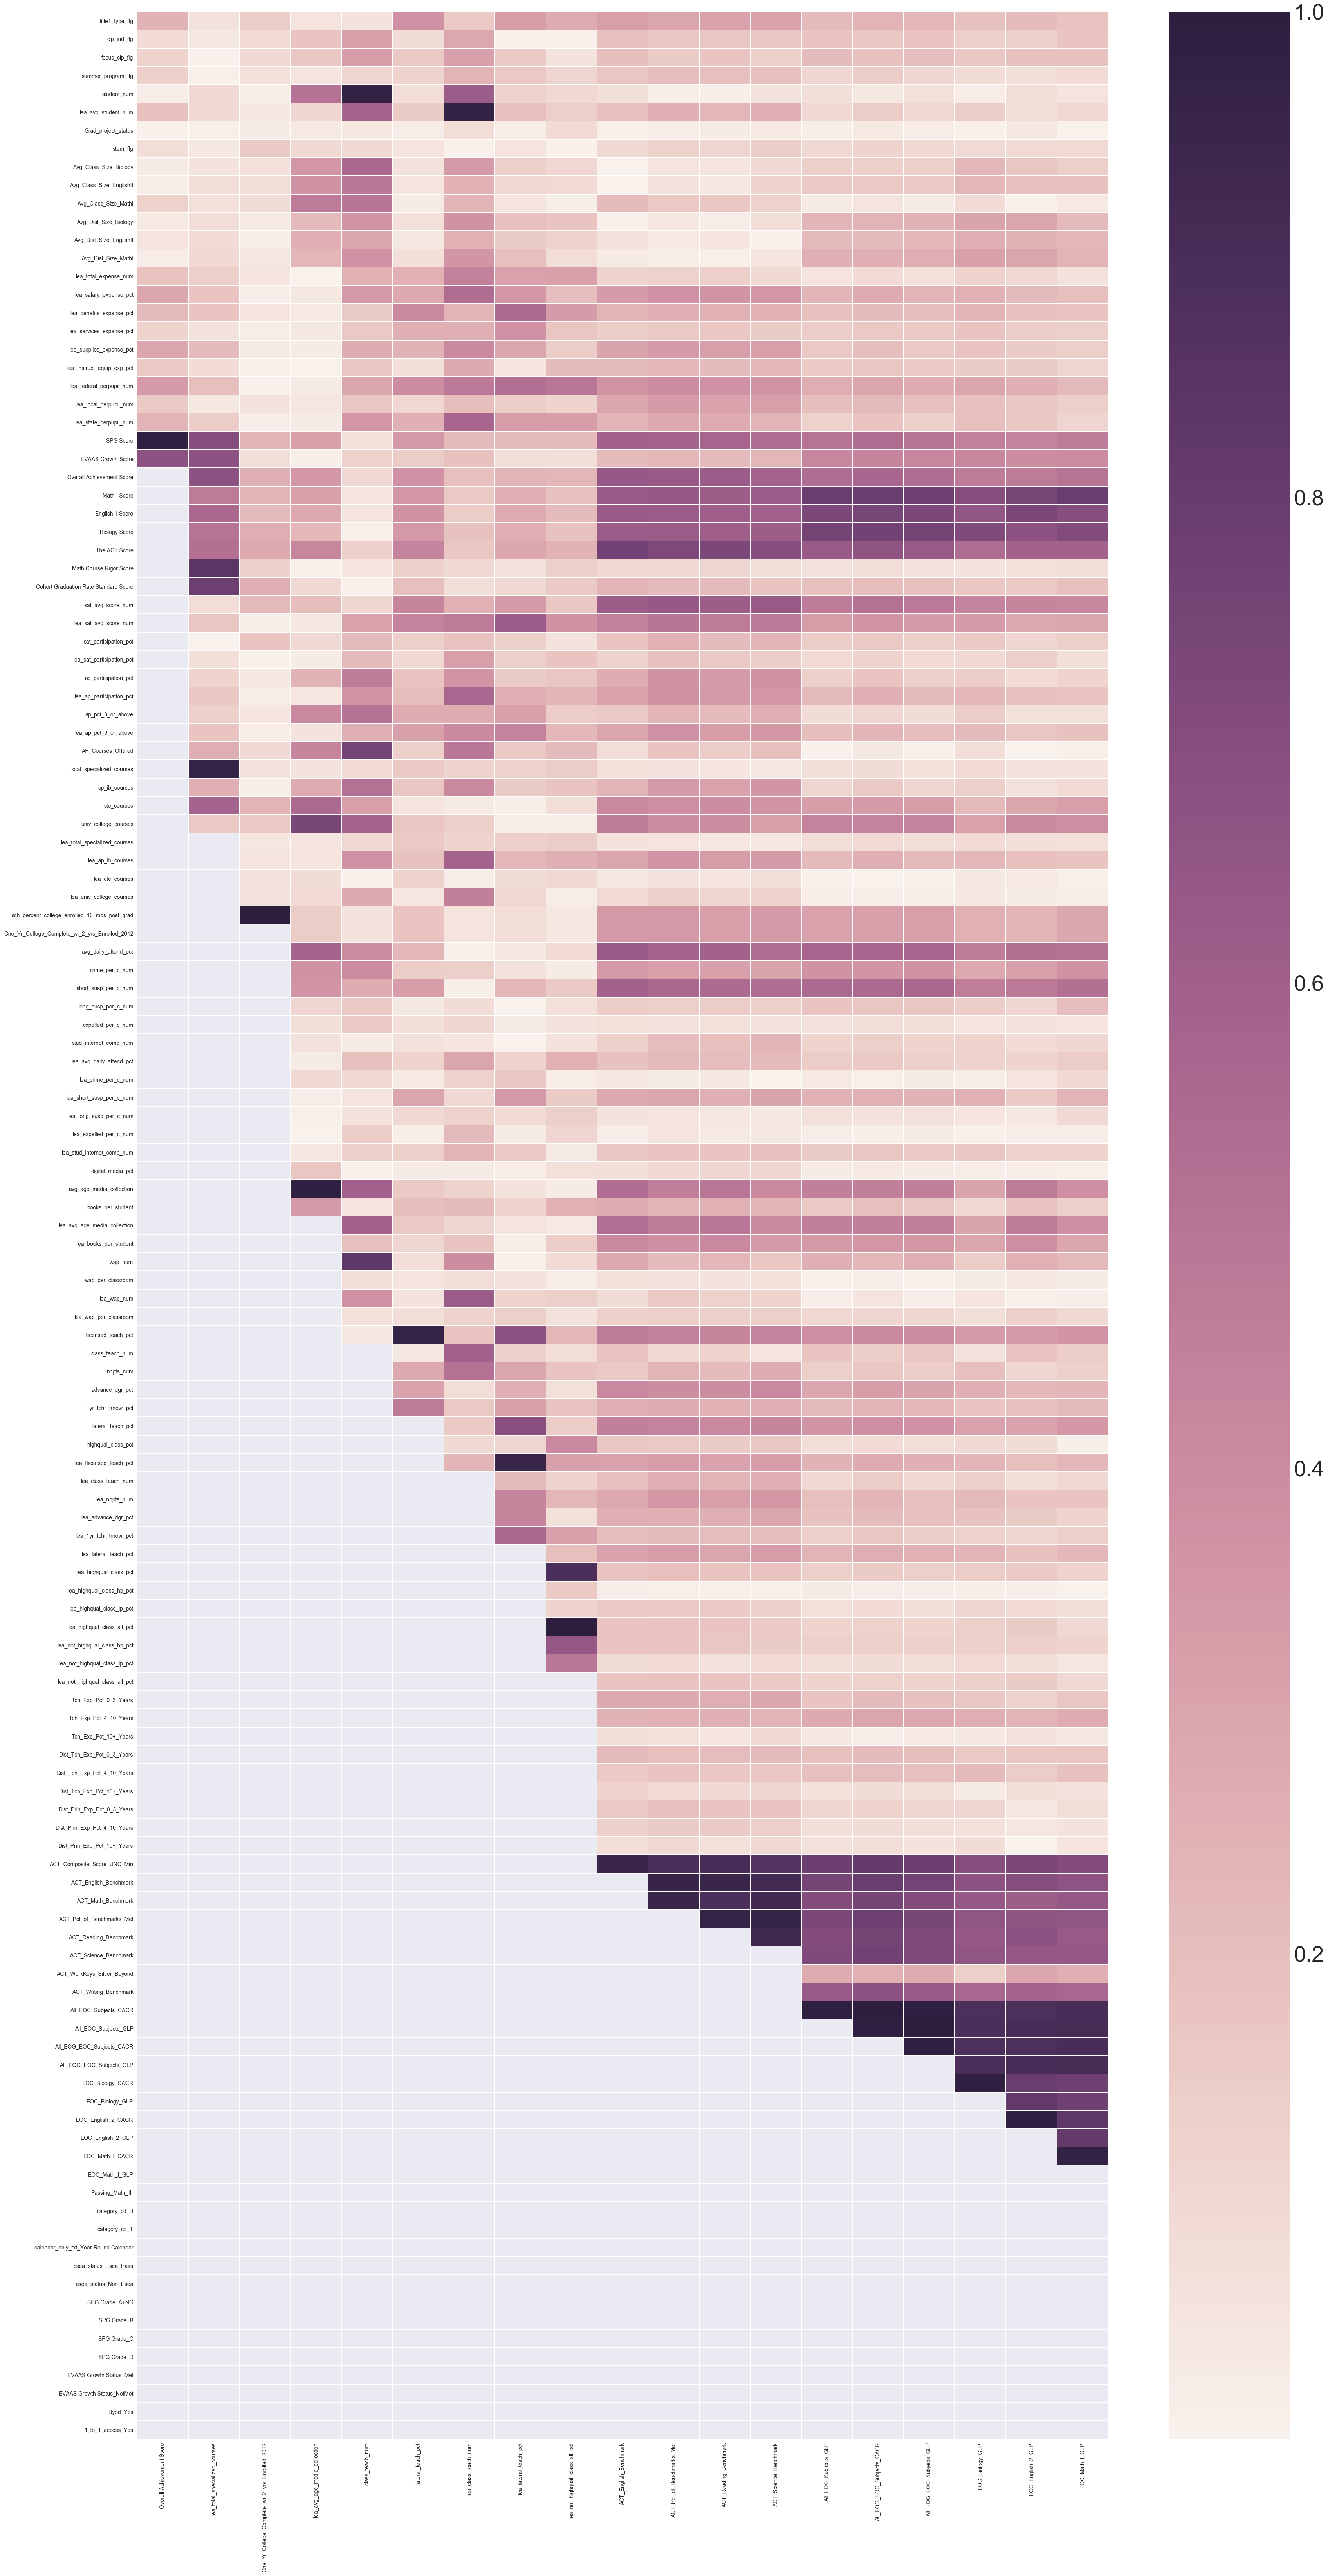

In [20]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr_matrix  = X_highSchools.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# plot the heatmap
fig, ax = plt.subplots(figsize=(40,80)) 
sns.set(font_scale=4)
sns.heatmap(upper[to_drop] , linewidths=.5, ax=ax)

In [21]:
#Print a list of the columns with correlations > .95
print("Columns with greater than .95 correlation")
print("*****************************************")
to_drop

Columns with greater than .95 correlation
*****************************************


['Overall Achievement Score',
 'lea_total_specialized_courses',
 'One_Yr_College_Complete_wi_2_yrs_Enrolled_2012',
 'lea_avg_age_media_collection',
 'class_teach_num',
 'lateral_teach_pct',
 'lea_class_teach_num',
 'lea_lateral_teach_pct',
 'lea_not_highqual_class_all_pct',
 'ACT_English_Benchmark',
 'ACT_Pct_of_Benchmarks_Met',
 'ACT_Reading_Benchmark',
 'ACT_Science_Benchmark',
 'All_EOC_Subjects_GLP',
 'All_EOG_EOC_Subjects_CACR',
 'All_EOG_EOC_Subjects_GLP',
 'EOC_Biology_GLP',
 'EOC_English_2_GLP',
 'EOC_Math_I_GLP']

In [22]:
#Restore fontscale back to normal after heatmap
sns.set(font_scale=1)

#Check columns before drop 
X_highSchools.info()

# Drop the highly correlated features from our training data 
X_highSchools = X_highSchools.drop(to_drop, axis=1)

#Check columns after drop 
print('*********************************************')
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 2 to 2419
Columns: 133 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(114), uint8(13)
memory usage: 424.6 KB
*********************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 2 to 2419
Columns: 114 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(95), uint8(13)
memory usage: 355.8 KB


In [25]:
X_highSchools.head(n=20)

,title1_type_flg,clp_ind_flg,focus_clp_flg,summer_program_flg,student_num,lea_avg_student_num,Grad_project_status,stem_flg,Avg_Class_Size_Biology,Avg_Class_Size_EnglishII,...,esea_status_Esea_Pass,esea_status_Non_Esea,SPG Grade_A+NG,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,Byod_Yes,1_to_1_access_Yes
2,False,False,False,False,108.0,985.0,False,False,13.0,13.0,...,0,1,0,0,0,0,0,0,0,0
9,False,False,True,False,1217.0,985.0,False,False,22.0,22.0,...,0,1,0,0,0,0,0,0,0,0
15,False,False,False,False,797.0,985.0,False,False,21.0,18.0,...,0,1,0,0,0,0,0,0,0,0
22,False,False,False,False,899.0,985.0,False,False,16.0,17.0,...,0,1,0,0,0,0,0,0,0,0
30,False,True,False,False,1508.0,985.0,False,False,22.0,23.0,...,0,1,0,0,0,0,0,0,0,0
34,False,False,False,False,1158.0,985.0,False,False,21.0,20.0,...,0,1,0,0,0,0,0,0,0,0
35,False,False,False,False,1211.0,985.0,False,False,22.0,23.0,...,0,1,0,0,0,0,0,0,0,0
38,False,False,False,True,1478.0,1478.0,True,False,18.0,17.0,...,0,1,0,0,0,0,0,0,0,1
48,False,False,False,False,450.0,450.0,True,False,16.0,16.0,...,0,1,0,0,0,0,0,0,1,0
52,False,False,False,True,210.0,261.0,True,False,19.0,21.0,...,0,1,0,0,0,0,0,0,0,0
